In [33]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
filename = "clf.csv"

In [5]:
df = pd.read_csv(filename, sep=";", quoting=2, encoding="utf-8")
df.head()

,species,redListCategory,ultimo_ano_coleta,ano_descricao,diferenca_data_coleta,endemica,total_ocorrencias,total_sinonimos
0,Piper percostatum,Near Threatened,1.0,0.0,738174.0,1.0,125.0,0.0
1,Piper cutucuense,Endangered,0.0,0.0,4456.0,1.0,3.0,0.0
2,Piper dodsonii,Endangered,1.0,0.0,0.0,1.0,6.0,0.0
3,Piper aereum,Least Concern,1.0,0.0,2615.0,0.0,25.0,0.0
4,Piper longicaudatum,Endangered,1.0,0.0,29560.0,1.0,46.0,0.0


In [22]:
X = df[["ultimo_ano_coleta", "ano_descricao", "diferenca_data_coleta", "endemica", "total_ocorrencias", "total_sinonimos"]]
y = df[["redListCategory"]]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

/home/xandao/miniconda3/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

5

In [24]:
f1_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f" Fold {fold}:")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"  X_train shape: {X_train.shape}")
    print(f"  X_test  shape: {X_test.shape}")
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    print(f"  F1 Score: {f1}")

/home/xandao/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


 Fold 0:
  X_train shape: (72, 6)
  X_test  shape: (19, 6)
  F1 Score: 0.7462887989203778
 Fold 1:
  X_train shape: (73, 6)
  X_test  shape: (18, 6)
  F1 Score: 0.7548732943469785
 Fold 2:
  X_train shape: (73, 6)
  X_test  shape: (18, 6)
  F1 Score: 0.7548732943469785
 Fold 3:
  X_train shape: (73, 6)
  X_test  shape: (18, 6)
  F1 Score: 0.5940170940170941
 Fold 4:
  X_train shape: (73, 6)
  X_test  shape: (18, 6)
  F1 Score: 0.7526695526695526


In [25]:
print(f"Média F1 Score: {np.mean(f1_scores)} ± {np.std(f1_scores)}")

Média F1 Score: 0.7205444068601963 ± 0.06334177869822931


In [26]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
feature_importance

,feature,importance
4,total_ocorrencias,0.376801
2,diferenca_data_coleta,0.284010
3,endemica,0.226186
0,ultimo_ano_coleta,0.113003
1,ano_descricao,0.000000
5,total_sinonimos,0.000000


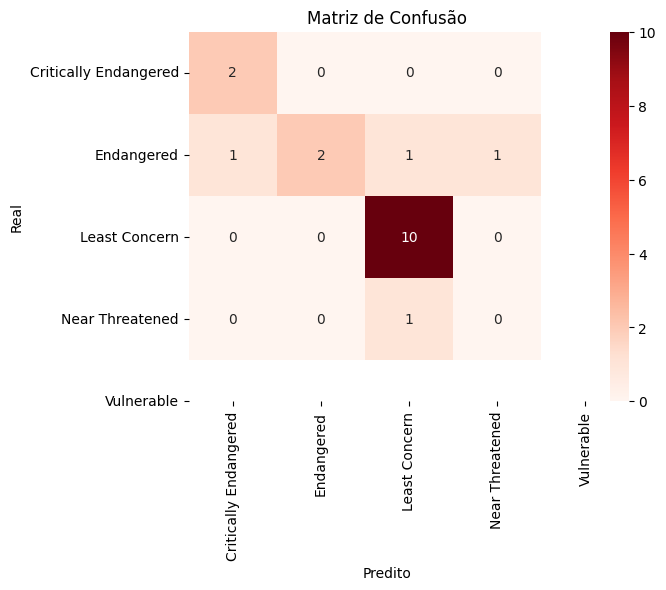

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()